In [15]:
#devtools::install_github("thebioengineer/tidytuesdayR")
library(tidyverse)
library(tidytuesdayR)

In [16]:
library(lubridate)


Attaching package: ‘lubridate’


The following objects are masked from ‘package:dplyr’:

    intersect, setdiff, union


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [2]:
tuesdata <- tidytuesdayR::tt_load(2020, week = 15)

--- Downloading #TidyTuesday Information for 2020-04-07 ----

--- Identified 3 files available for download ----

--- Downloading files ---

Warning message:
“230562 parsing failures.
  row        col           expected actual                                                                                file
22069 bib_number 1/0/T/F/TRUE/FALSE     41 '/var/folders/w1/2jzvgfzs1h16xwvjjjh7mn8h0000gn/T//RtmpwEileD/file1d463979ae22.csv'
22070 bib_number 1/0/T/F/TRUE/FALSE     11 '/var/folders/w1/2jzvgfzs1h16xwvjjjh7mn8h0000gn/T//RtmpwEileD/file1d463979ae22.csv'
22071 bib_number 1/0/T/F/TRUE/FALSE     2  '/var/folders/w1/2jzvgfzs1h16xwvjjjh7mn8h0000gn/T//RtmpwEileD/file1d463979ae22.csv'
22072 bib_number 1/0/T/F/TRUE/FALSE     3  '/var/folders/w1/2jzvgfzs1h16xwvjjjh7mn8h0000gn/T//RtmpwEileD/file1d463979ae22.csv'
22073 bib_number 1/0/T/F/TRUE/FALSE     5  '/var/folders/w1/2jzvgfzs1h16xwvjjjh7mn8h0000gn/T//RtmpwEileD/file1d463979ae22.csv'
..... .......... .................. ...... ...........

In [59]:
tdf_winners <- tuesdata$tdf_winners %>% 
                            mutate(year = year(start_date), 
                                   speed = distance / time_overall)
tdf_stages <- tuesdata$tdf_stages
stage_data <- tuesdata$stage_data

In [18]:
tdf_winners %>% head()

edition,start_date,winner_name,winner_team,distance,time_overall,time_margin,stage_wins,stages_led,height,weight,age,born,died,full_name,nickname,birth_town,birth_country,nationality,year
<dbl>,<date>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,1903-07-01,Maurice Garin,La Française,2428,94.55389,2.989167,3,6,1.62,60,32,1871-03-03,1957-02-19,NA,The Little Chimney-sweep,Arvier,Italy,France,1903
2,1904-07-02,Henri Cornet,Conte,2428,96.09861,2.270556,1,3,NA,NA,19,1884-08-04,1941-03-18,NA,Le rigolo (The joker),Desvres,France,France,1904
3,1905-07-09,Louis Trousselier,Peugeot–Wolber,2994,NA,NA,5,10,NA,NA,24,1881-06-29,1939-04-24,NA,Levaloy / Trou-trou,Paris,France,France,1905
4,1906-07-04,René Pottier,Peugeot–Wolber,4637,NA,NA,5,12,NA,NA,27,1879-06-05,1907-01-25,NA,NA,Moret-sur-Loing,France,France,1906
5,1907-07-08,Lucien Petit-Breton,Peugeot–Wolber,4488,NA,NA,2,5,NA,NA,24,1882-10-18,1917-12-20,Lucien Georges Mazan,Lucien Petit-Breton,Plessé,France,France,1907
6,1908-07-13,Lucien Petit-Breton,Peugeot–Wolber,4497,NA,NA,5,13,NA,NA,25,1882-10-18,1917-12-20,Lucien Georges Mazan,Lucien Petit-Breton,Plessé,France,France,1908


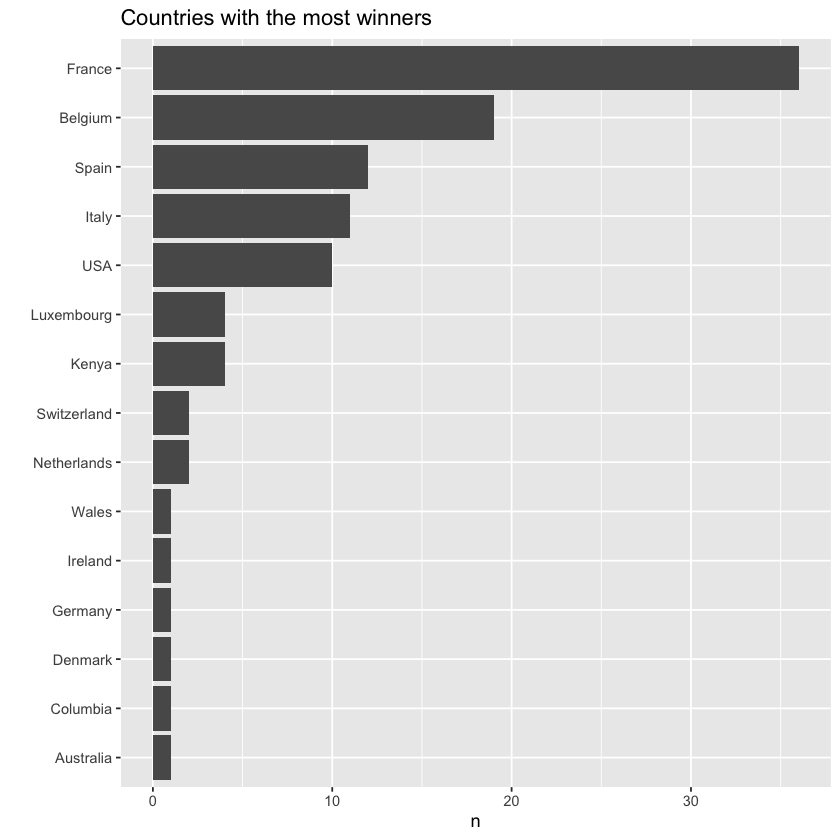

In [12]:
tdf_winners %>% 
            count(birth_country, sort = TRUE) %>%
            mutate(birth_country = fct_reorder(birth_country, n))  %>% 
            ggplot(aes(n, birth_country)) + 
                geom_col() +
                labs(y = "", title = "Countries with the most winners")

In [14]:
tdf_winners  %>% 
        count(winner_name, birth_country, sort = TRUE) %>% 
        head()

winner_name,birth_country,n
<chr>,<chr>,<int>
Lance Armstrong,USA,7
Bernard Hinault,France,5
Eddy Merckx,Belgium,5
Jacques Anquetil,France,5
Miguel Induráin,Spain,5
Chris Froome,Kenya,4


In [50]:
by_decade <- tdf_winners %>%
                    group_by(decade = 10 * (year %/% 10)) %>%
                    filter(decade >= 1910) %>%
                    summarise(winner_age = mean(age, na.rm = TRUE), 
                              winner_height = mean(height, na.rm = TRUE), 
                              winner_weight = mean(weight, na.rm = TRUE), 
                              winner_margin = mean(time_margin, na.rm = TRUE), 
                              winner_speed = mean(speed, na.rm = TRUE))  

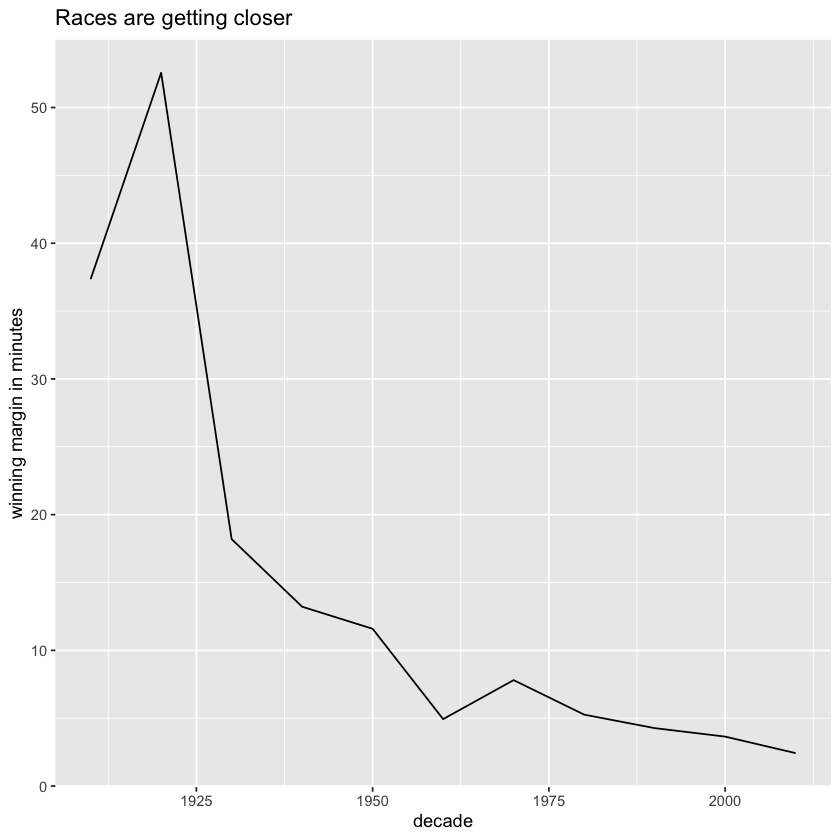

In [46]:
by_decade %>% 
        ggplot(aes(decade, 60 * winner_margin)) +
            geom_line() +
            labs(y = "winning margin in minutes", 
                 x = "decade", title = "Races are getting closer")

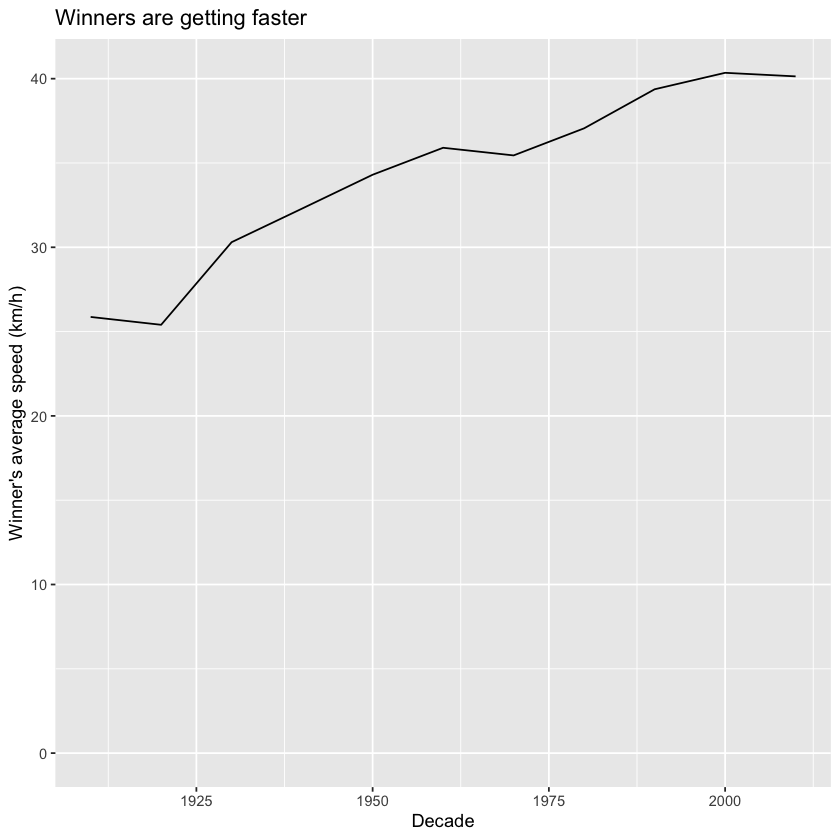

In [60]:
by_decade %>% 
        ggplot(aes(decade, winner_speed)) +
            geom_line() +
                expand_limits(y = 0) + 
                labs(y = "Winner's average speed (km/h)", 
                     x = "Decade", 
                     title = "Winners are getting faster")

In [69]:
names(tdf_winners)

[1] "edition"       "start_date"    "winner_name"   "winner_team"  
 [5] "distance"      "time_overall"  "time_margin"   "stage_wins"   
 [9] "stages_led"    "height"        "weight"        "age"          
[13] "born"          "died"          "full_name"     "nickname"     
[17] "birth_town"    "birth_country" "nationality"   "year"         
[21] "speed"

### Life expentacy

In [71]:
library(survival)

In [81]:
surv_model <- tdf_winners %>% 
                    distinct(winner_name, .keep_all = TRUE) %>%
                    transmute(winner_name, 
                              birth_year = year(born), 
                              death_year = year(died), 
                              dead = as.integer(!is.na(death_year))) %>%
                    mutate(age_at_death = coalesce(death_year, 2020) - birth_year)  %>% 
                    survfit(Surv(age_at_death, dead) ~ 1, data = .)  

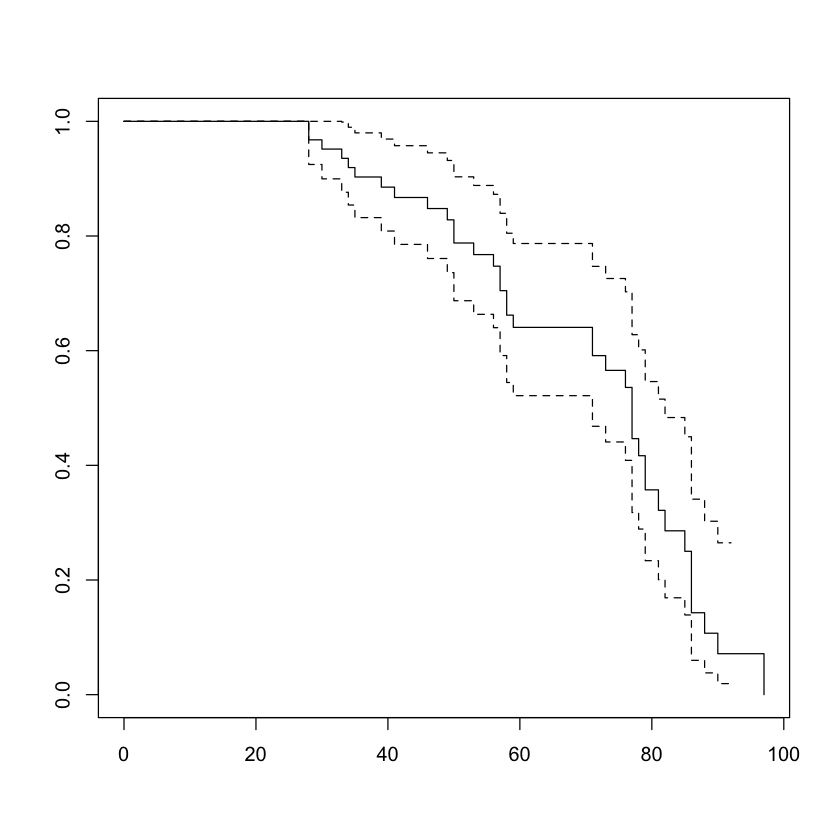

In [82]:
surv_model %>% plot()

In [86]:
library(broom)
glance(surv_model)

#median life expectancy of tdf winner is 77

records,n.max,n.start,events,rmean,rmean.std.error,median,conf.low,conf.high
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,63,63,38,69.62491,2.685674,77,71,82


In [87]:
tdf_winners %>% 
        distinct(winner_name, .keep_all = TRUE) %>%
        filter(!is.na(died)) %>% 
        dim()

# 38 out of 63 have died...

[1] 38 21

# Stage Data: